Todas las librerias que se utilizaron para la etapa final del proyecto son las siguientes

In [2]:
import datetime
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
import rioxarray
import xarray as xr

Primero se busca dentro de los tutoriales las ecoregiones que ya habian subido al repositorio

In [33]:
datos_ruta = Path("~/shared/proyecto5")

In [34]:
ecoregiones_gdf = gpd.read_file(datos_ruta / "MEOW" / "meow_ecos.shp")

In [35]:
def seleccion_ecoregion(gdf, ecoregion):
    sel_gdf = gdf[gdf["ECOREGION"] == ecoregion]
    sel_bordes_df = sel_gdf.geometry.bounds
    sel_bordes = dict(
        minx=sel_bordes_df.minx.values[0],
        maxx=sel_bordes_df.maxx.values[0],
        miny=sel_bordes_df.miny.values[0],
        maxy=sel_bordes_df.maxy.values[0],
    )
    return sel_gdf, sel_bordes

In [36]:
def limpiarnombre(s):
    return s.replace("/", "-").replace(" ", "-")

Ahora cargamos nuestra informacion ERDDAP, se ocupa trabajar los datos en un xarray porque son mulidimencionales,
en otro caso se trabajaria como un dataframe 

In [37]:
erddap_opendap_url = 'https://coastwatch.pfeg.noaa.gov/erddap/es/griddap/erdMH1chlamday_R2022SQ'

fuente_ds = xr.open_dataset(erddap_opendap_url)

In [38]:
fuente_ds

<xarray.Dataset>
Dimensions:    (time: 246, latitude: 4320, longitude: 8640)
Coordinates:
  * time       (time) datetime64[ns] 2002-07-16 2002-08-16 ... 2022-12-16
  * latitude   (latitude) float32 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * longitude  (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Data variables:
    chlor_a    (time, latitude, longitude) float32 ...
Attributes: (12/52)
    _lastModified:                     2023-03-02T00:12:58.000Z
    cdm_data_type:                     Grid
    Conventions:                       CF-1.6 ACDD-1.3, COARDS
    creator_email:                     data@oceancolor.gsfc.nasa.gov
    creator_name:                      NASA/GSFC/OBPG
    creator_type:                      group
    ...                                ...
    summary:                           Moderate Resolution Imaging Spectrorad...
    temporal_range:                    month
    time_coverage_end:                 2022-12-16T00:00:00Z
    time_coverage_start:               2002-07-16T00:00:00Z
    title:                             Chlorophyll-a, Aqua MODIS, NPP, L3SMI,...
    Westernmost_Easting:               -179.9792

El siguiente paso es convertir los byte es MB por pura simplificacion, no tiene efecto con los resultados

In [39]:
print(f"Tamaño del dataset: {fuente_ds.nbytes/1e6} MB")

Tamaño del dataset: 36727.657008 MB


Ahora si! escojemos la ecoregion deseada, con su respectivo nombre de acuerdo a la lista mencionada en el repositorio ECOREGIONES
tomado de Spalding et al. (2007).

* apartir de todos los datos satelitales contenidos, seleccionamos el intervalo de tiempo para extraerlo

In [40]:
ecoregion_seleccion = "Malvinas/Falklands"

año_inicio = 2004
año_final= 2005

ecoregion_seleccion_limpio = limpiarnombre(ecoregion_seleccion)

In [41]:
ecoregion_gdf, ecoregion_bordes = seleccion_ecoregion(ecoregiones_gdf, ecoregion_seleccion)

Estas son las coordenadas exactas de nuestra ecoregion, se ocupan para describir la metodologia

In [42]:
ecoregion_bordes

{'minx': -64.16069762302112,
 'maxx': -54.400302736409856,
 'miny': -55.79757776174819,
 'maxy': -47.80757195687869}

In [44]:
subset_ds = fuente_ds.sel(
    time=slice(datetime.datetime(año_inicio,1,1), datetime.datetime(año_final,12,31)), 
    latitude=slice(ecoregion_bordes['maxy'], ecoregion_bordes['miny']),
    longitude=slice(ecoregion_bordes['minx'], ecoregion_bordes['maxx'])
)

In [45]:
subset_ds

<xarray.Dataset>
Dimensions:    (time: 24, latitude: 192, longitude: 234)
Coordinates:
  * time       (time) datetime64[ns] 2004-01-16 2004-02-16 ... 2005-12-16
  * latitude   (latitude) float32 -47.81 -47.85 -47.9 ... -55.69 -55.73 -55.77
  * longitude  (longitude) float32 -64.15 -64.1 -64.06 ... -54.52 -54.48 -54.44
Data variables:
    chlor_a    (time, latitude, longitude) float32 ...
Attributes: (12/52)
    _lastModified:                     2023-03-02T00:12:58.000Z
    cdm_data_type:                     Grid
    Conventions:                       CF-1.6 ACDD-1.3, COARDS
    creator_email:                     data@oceancolor.gsfc.nasa.gov
    creator_name:                      NASA/GSFC/OBPG
    creator_type:                      group
    ...                                ...
    summary:                           Moderate Resolution Imaging Spectrorad...
    temporal_range:                    month
    time_coverage_end:                 2022-12-16T00:00:00Z
    time_coverage_start:               2002-07-16T00:00:00Z
    title:                             Chlorophyll-a, Aqua MODIS, NPP, L3SMI,...
    Westernmost_Easting:               -179.9792

In [46]:
print(f"Tamaño del dataset: {subset_ds.nbytes/1e6} MB")

Tamaño del dataset: 4.314984 MB


In [47]:
%%time 
subset_ds.load();

CPU times: user 120 ms, sys: 66.5 ms, total: 186 ms
Wall time: 2min 35s


In [48]:
subset_ds

<xarray.Dataset>
Dimensions:    (time: 24, latitude: 192, longitude: 234)
Coordinates:
  * time       (time) datetime64[ns] 2004-01-16 2004-02-16 ... 2005-12-16
  * latitude   (latitude) float32 -47.81 -47.85 -47.9 ... -55.69 -55.73 -55.77
  * longitude  (longitude) float32 -64.15 -64.1 -64.06 ... -54.52 -54.48 -54.44
Data variables:
    chlor_a    (time, latitude, longitude) float32 3.218 3.194 ... 0.3135 0.3287
Attributes: (12/52)
    _lastModified:                     2023-03-02T00:12:58.000Z
    cdm_data_type:                     Grid
    Conventions:                       CF-1.6 ACDD-1.3, COARDS
    creator_email:                     data@oceancolor.gsfc.nasa.gov
    creator_name:                      NASA/GSFC/OBPG
    creator_type:                      group
    ...                                ...
    summary:                           Moderate Resolution Imaging Spectrorad...
    temporal_range:                    month
    time_coverage_end:                 2022-12-16T00:00:00Z
    time_coverage_start:               2002-07-16T00:00:00Z
    title:                             Chlorophyll-a, Aqua MODIS, NPP, L3SMI,...
    Westernmost_Easting:               -179.9792

In [49]:
subset_ds.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
subset_ds.rio.write_crs("epsg:4326", inplace=True)

ecoregion_mascara_ds = subset_ds.rio.clip(
    ecoregion_gdf.geometry.values, 
    ecoregion_gdf.crs, 
    invert=False,
    drop=False,
)

In [50]:
ecoregion_mascara_ds

<xarray.Dataset>
Dimensions:      (latitude: 192, longitude: 234, time: 24)
Coordinates:
  * latitude     (latitude) float64 -47.81 -47.85 -47.9 ... -55.69 -55.73 -55.77
  * longitude    (longitude) float64 -64.15 -64.1 -64.06 ... -54.48 -54.44
  * time         (time) datetime64[ns] 2004-01-16 2004-02-16 ... 2005-12-16
    spatial_ref  int64 0
Data variables:
    chlor_a      (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes: (12/52)
    _lastModified:                     2023-03-02T00:12:58.000Z
    cdm_data_type:                     Grid
    Conventions:                       CF-1.6 ACDD-1.3, COARDS
    creator_email:                     data@oceancolor.gsfc.nasa.gov
    creator_name:                      NASA/GSFC/OBPG
    creator_type:                      group
    ...                                ...
    summary:                           Moderate Resolution Imaging Spectrorad...
    temporal_range:                    month
    time_coverage_end:                 2022-12-16T00:00:00Z
    time_coverage_start:               2002-07-16T00:00:00Z
    title:                             Chlorophyll-a, Aqua MODIS, NPP, L3SMI,...
    Westernmost_Easting:               -179.9792

A partir de aqui ya se esta trabajando con el subgrupo de datos 2004 al 2005

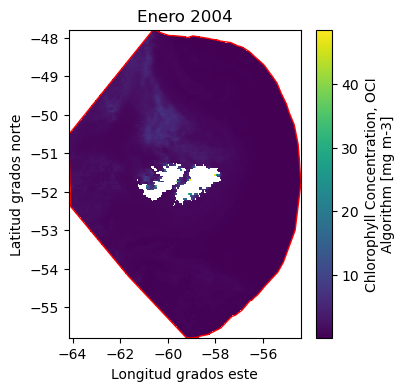

In [51]:
_, ax = plt.subplots(ncols=1, figsize=(4,4))
ecoregion_mascara_ds.chlor_a.isel(time=0).plot(ax=ax)
ecoregion_gdf.plot(ax=ax, edgecolor='red', facecolor='none');
plt.title('Enero 2004')
plt.xlabel('Longitud grados este')
plt.ylabel('Latitud grados norte')

plt.savefig(f"mapa-t0-{ecoregion_seleccion_limpio}.png")
plt.show();

Este mapa es el resultado final de extraer los datos en un periodo de tiempo dentro de una mascara determinada 
*le agrege algunas leyendas en español, pero si se las quitamos apareceran las predeterminadas 

In [52]:
geopromedio_ecoregion_ds = ecoregion_mascara_ds.chlor_a.mean(dim=('latitude', 'longitude'))

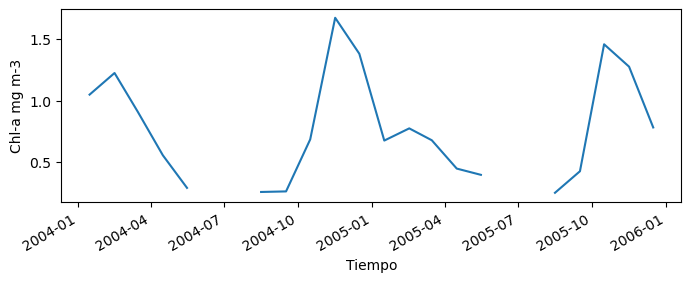

In [53]:
da = subset_ds.chlor_a

geopromedio_ecoregion_ds.plot(figsize=(8,2.5))
plt.ylabel(f"{da.standard_name}\n({da.units}")
plt.title(None)
plt.xlabel('Tiempo')
plt.ylabel('Chl-a mg m-3')

plt.savefig(f"serietemporal-{ecoregion_seleccion_limpio}.png")
plt.show();